<a href="https://colab.research.google.com/github/AlecTraas/computational-geo-lab/blob/main/Colab/Kai/hyperbolic_convex_hull.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# plots a geodesic segment through complex numbers a and b, with color c
def plot_geodesic(a,b,c):
    if abs(a.real - b.real) <= 2/900:
      plt.plot([a.real,b.real],[a.imag,b.imag],color=c)
      return
    o = ((a.real**2 + a.imag**2 - b.real**2 - b.imag**2) / (2*(a.real - b.real)), 0)
    x = np.linspace(min(a.real,b.real), max(a.real,b.real), 1000)
    arc = lambda x: np.sqrt(np.linalg.norm(np.array([a.real,a.imag]) - np.array(o))**2 - (x - o[0])**2) + o[1]
    y = [arc(xi) for xi in x]
    plt.plot(x,y,color=c)

In [5]:
# plots a list of points p, with color c
def plot_point(p,c):
    plt.scatter(np.real(p), np.imag(p), s=10, c=c, alpha=1)

In [6]:
# returns the distance between two points a and b
def dist(a,b):
  numer = np.abs(a - np.conjugate(b)) + np.abs(a - b)
  denom = np.abs(a - np.conjugate(b)) - np.abs(a - b)
  return np.log(numer/denom)

In [21]:
# returns the angle ∠ACB given points a, b, c
def angle(pa,pb,pc):
  a = dist(pb,pc)
  b = dist(pa,pc)
  c = dist(pa,pb)
  numer = np.cosh(a) * np.cosh(b) - np.cosh(c)
  denom = np.sinh(a) * np.sinh(b)
  return np.arccos(numer/denom)

In [8]:
# applies the Cayley transform to a set of points z in the upper half plane
def cayley(z):
  return (z-1j)/(z+1j)

<ipython-input-21-426af828b714>:8: RuntimeWarning: invalid value encountered in scalar divide
  return np.arccos(numer/denom)
<ipython-input-21-426af828b714>:8: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(numer/denom)


[(-8.945573605695436+5.664394788997056j), (9.340310754260017+9.32918826633753j), (9.624736697212363+7.21550621636154j), (9.48032173895782+6.2384508738095334j), (8.985395262439116+1.118270974629475j), (8.323257969807965+0.8235494420226974j), (6.00489602720118+1.2027299797699664j), (4.834586663298655+0.2754399979222366j), (4.125746650610207+1.4431170757496559j), (3.130567777526972+2.2991469435762335j), (-0.3111768677901967+2.7969767904850986j), (-2.169182011894442+1.9378072858346929j), (-4.528557129669133+1.6801368856291266j), (-4.981533317218869+1.791002930807284j), (-8.088234205161122+0.07076250186982325j), (-6.623881472945974+7.973239195239215j)]


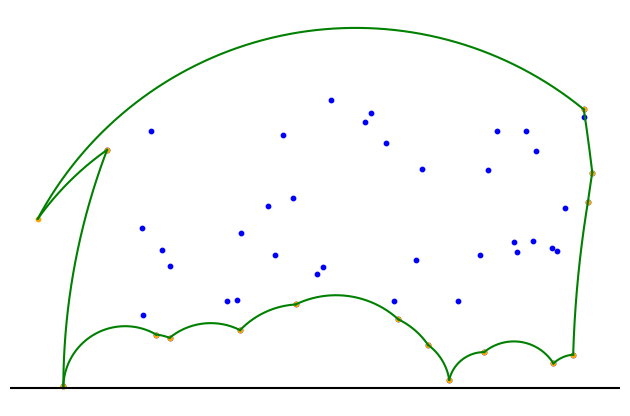

In [76]:
n = 50
points = np.random.uniform(-10, 10, n) + np.random.uniform(0, 10, n) * 1j
# points = [-2+4j,3.5+3.5j,-1+3j,-3+1j,-1+2j]
points = sorted(points, key=lambda z: z.real)

hull_pts = []
hull_pts.append(points[0])

points = points[1:]

# this could break, but it is soooo unlikely.
next_pt = hull_pts[0] - min(1,hull_pts[0].imag - 0.0001)*1j

# initial hull point
max_a = 0
max_i = -1
for k,p in enumerate(points):
  a = angle(next_pt,p,hull_pts[0])
  if a > max_a:
    max_i = k
    max_a = a
next_pt = points[max_i]
# del points[max_i]

# pts [(1,2),(3,3),(7,6),(2,6),(5,1)]
# hull_pts []
# while the selected point isn't the one we started with:
#    for each point in pts:
#       if the angle formed by the previous point, the current point, and the next point (a) is the greatest observed yet:
#          note the index and angle
#    assign the current point to the hull set (effectively making it the previous point)
#    assing the next point (max-angled one we found earlier) to be the current point
#    clear the old next point from pts so that we don't reselect an old point

i = 0
while next_pt not in hull_pts:
  max_a = 0
  max_i = -1
  for j,p in enumerate(points):
    a = angle(hull_pts[i],p,next_pt)
    if a > max_a:
      max_i = j
      max_a = a
  i += 1
  hull_pts.append(next_pt)
  next_pt = points[max_i]

print(hull_pts)

fig, ax = plt.subplots()
ax.axhline(0, color='black')

# plot upper half plane points
plot_point(points,'b')
plot_point(hull_pts,'orange')

for i in range(0,len(hull_pts)-1):
  plot_geodesic(hull_pts[i],hull_pts[i+1],'green')
plot_geodesic(hull_pts[0],hull_pts[len(hull_pts)-1],'green')

# plot poincare disc points
# plot_point(cayley(points),'g')

# unit circle
# theta = np.linspace(0, 2*np.pi, 1000)
# x = np.cos(theta)
# y = np.sin(theta)
# plt.plot(x, y, color = 'r')

# formatting
ax.axis('off')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()